In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 44kB/s 
     |████████████████████████████████| 512kB 45.2MB/s 
     |████████████████████████████████| 3.8MB 56.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=19d30b0af287782bc87c4fa686a1886d2730e8fe7fbe4a5956156b31b7abdb16
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 1.12.2
    Uninstalling tensorboard-1.12.2:
      Successfully uninstalled tensorboard-1.12.2
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installatio

In [ ]:
# # steps

# 1->read all captions
# 2->map image with their all repective captions
# 3->data cleaning to all captions
# 4-> create vocab with threshold of 10 so reduce overfitting
# 5-> Prepare train/test data
# 6-> Append start and end of sequence
# 7-> Transfer learning model setup
# 8-> Prepare image data according to the model
# 9->Prepare caption data according to data
# 10->  preprocess the data generator ready to fit i model
# 11->use word embedddings to train 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [14]:
DATA_PATH=r'gdrive/My Drive/kaggle/flicker/flicker8k/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
DATA_PATH_1=r'gdrive/My Drive/kaggle/flicker/flicker8k/Flickr_Data/Flickr_TextData/'
IMAGE_PATH=r'gdrive/My Drive/kaggle/flicker/flicker8k/Flickr_Data/Images/'
DEFAULT_PATH=r'gdrive/My Drive/kaggle/flicker/flicker8k/Flickr_Data/Flickr_TextData/'
MODEL_WEIGHT=r'gdrive/My Drive/kaggle/flicker/flicker8/trained weights/'
PICKL_FILE=r'gdrive/My Drive/kaggle/flicker/flicker8k/PICKL_FILE/'

In [12]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [13]:
cap=readTextFile('gdrive/My Drive/kaggle/flicker/flicker8k/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')


Reading  all captions

In [16]:
captions  = readTextFile(DATA_PATH)
captions = captions.split('\n')[:-1]   # remove last line (blank)

In [17]:
print(len(captions))

40460


In [20]:
print(captions[:5])

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .', '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']


In [ ]:
first,second=captions[1].split('\t')
first=first.split('.')[0]
print(first,second)

1000268201_693b08cb0e A girl going into a wooden building .


2. )map image with their all repective captions

In [ ]:
#  making dictionary to map image to respective captions

descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [ ]:
#descriptions

In [ ]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

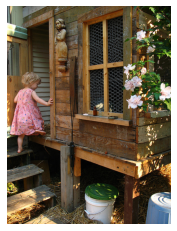

In [ ]:
# readig images

import cv2
import matplotlib.pyplot as plt
img=cv2.imread(IMAGE_PATH+'1000268201_693b08cb0e.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()


3.) data cleaning to all captions

In [22]:
# data Cleaning
# here we dont do cleanig of is,am are other wise our model will not be able to predict correct word
# dog is running  will be predicted as  dog run   (we will not do stemming also) 

import re

def clean_text(sentence):
  sentence=sentence.lower()
  sentence=re.sub("[^a-z]+"," ",sentence)   # remove all not alphabetic character and replace with space 
  sentence=sentence.split(' ')
  sentence=[s for s in sentence if len(s) >1]

  sentence=" ".join(sentence)

  return sentence

In [23]:
clean_text("A cat is sitting over 548 %^%jjhj ug the house # 64")

'cat is sitting over jjhj ug the house'

In [ ]:
# now updating all captions to clean text

for key ,caption_list in descriptions.items():
  for i in range(len(caption_list)):
    caption_list[i]=clean_text(caption_list[i])


In [ ]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [24]:
# now writing this updated captions in to new file

In [ ]:
with open(DATA_PATH_1+'descriptions_1_.txt' ,'w') as f:
  f.write(str(descriptions))

In [27]:
DATA_PATH_1=r'gdrive/My Drive/kaggle/flicker/flicker8k/Flickr_Data/Flickr_TextData/descriptions_1_.txt'

Vocabulary 

4.) create vocab with threshold of 10 to reduce overfitting

In [28]:
discriptions=None
with open(DATA_PATH_1,'r') as f:
  descriptions=f.read()

In [29]:
descriptions

Output hidden; open in https://colab.research.google.com to view.

In [30]:
import json
json_sting=descriptions.replace("'","\"")
descriptions=json.loads(json_sting)

In [31]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [32]:
type(descriptions)

dict

In [33]:
# preparing vocab

# step 1  getting unique words

vocab=set()

for cab in descriptions.keys():
  #print(cab)
  [vocab.update(sentence.split()) for sentence in descriptions[cab]]

print("size of vocab : %d "% len(vocab))









size of vocab : 8424 


In [34]:
# step 2    getting all words

tot_words=[]

for key in descriptions.keys():
  [tot_words.append(i) for dic in descriptions[key] for i in dic.split()]


print("Total Words %d"%len(tot_words))



Total Words 373837


In [35]:
# step 3 getting count of each of words in tot_words    total count of 8424 words

import collections

counter=collections.Counter(tot_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8424


In [36]:
# step 4  now filter the words which are less than threshold of more than 10

#sort according to frequency

sort_freq=sorted(freq_cnt.items() ,reverse=True,key=lambda x:x[1])
#sort_freq

In [37]:
# filtering based on threshold ignoring freq less than 10

threshold=10
tot_words=[x[0] for x in sort_freq if x[1] > threshold]   # as x[1]->frequency and x[0] ->word
tot_words

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'at',
 'people',
 'water',
 'red',
 'young',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'shirt',
 'down',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'person',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'holding',
 'up',
 'field',
 'small',
 'by',
 'large',
 'green',
 'one',
 'group',
 'yellow',
 'her',
 'walking',
 'children',
 'men',
 'into',
 'air',
 'beach',
 'near',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'off',
 'out',
 'rock',
 'next',
 'play',
 'orange',
 'looking',
 'pink',
 'player',
 'camera',
 'their',
 'pool',
 'hat',
 'jacket',
 'boys',
 'women',
 'around',
 'behind',
 'some',
 'background',
 'dirt',
 'toy',
 'soccer',
 'sits',
 'dressed',
 

In [38]:
print(len(tot_words))

1845


In [ ]:
with open(DEFAULT_PATH+'unique_threshold_1.txt','w') as f:
  for listitem in tot_words:
    f.write('%s\n' % listitem)



In [15]:
tot_words = []

# open file and read the content in a list
with open(DEFAULT_PATH+'unique_threshold_1.txt', 'r') as f:
    for line in f:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        tot_words.append(currentPlace)

In [16]:
len(tot_words)

1845

In [ ]:
# here vocab is completed

Prepare Train/Test Data

In [ ]:

train_file_data=readTextFile(DEFAULT_PATH+'Flickr_8k.trainImages.txt')

dev_file_data=readTextFile(DEFAULT_PATH+'Flickr_8k.devImages.txt')
test_file_data = readTextFile(DEFAULT_PATH+"Flickr_8k.testImages.txt")

In [ ]:
train_file_data[1]

'5'

In [ ]:
train_file_data[1]

'5'

In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
dev = [row.split(".")[0] for row in dev_file_data.split("\n")[:-1]]


In [ ]:
dev[:5]

['2090545563_a4e66ec76b',
 '3393035454_2d2370ffd4',
 '3695064885_a6922f06b2',
 '1679557684_50a206e4a9',
 '3582685410_05315a15b8']

In [ ]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

Append start and end of sequence

In [ ]:
# as now we have to train the sentence aganst features through images
# so what we want is that append start and end of sentence
# so while prediction model should know from which world to start and which word to finish
# so model should not predict like ==>  which boy is talking or like something
# should start which sesnsable meaning world and should have proper ending


train_descriptions={}

for key in descriptions.keys():
  train_descriptions[key]=[]
  for cap in descriptions[key]:
    new_str= "startseq "  + cap + " endseq"
    train_descriptions[key].append(new_str)



In [ ]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
with open(DEFAULT_PATH+'unique_threshold_start_end_seq.txt','w') as f:
  f.write(str(train_descriptions))
  

In [17]:
train_descriptions=None
with open(DEFAULT_PATH+'unique_threshold_start_end_seq.txt','r') as f:
  train_descriptions=f.read()
json_sting=train_descriptions.replace("'","\"")
train_descriptions=json.loads(json_sting)

In [18]:
type(train_descriptions)

dict

In [ ]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# model works preprocessing images


In [ ]:
import json
train_descriptions=None
with open(DEFAULT_PATH+'unique_threshold_start_end_seq.txt','r') as f:
  train_descriptions=f.read()
json_sting=train_descriptions.replace("'","\"")
train_descriptions=json.loads(json_sting)


Transfer learningn Resnet 50

In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

Using TensorFlow backend.


In [ ]:
# IMages  ->features extract
# extracted features->in lstm model

Transfer learning model setup

IMages  ->features extract

extracted features->in lstm model

In [2]:
model=ResNet50(weights='imagenet',input_shape=((224,224,3)))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

102858752/102853048 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 11

In [ ]:
# avg_pool (GlobalAveragePooling2D) it averages the value in l*b to one 
# like avg_pool (GlobalAveragePooling2D(2048)) is done on 7*7*2048 it will convert to 2048 vector
# reducing each channel feature to one digit      like summation(n,m) A[i][j]/(n*m)
# now we will use this layer to get features out of images
# as this is last second layer
from keras.models import Model
from keras.preprocessing import image
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
import numpy as np
def preprocess_img(img):
  img=image.load_img(img,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)

  # normalising image as per resnet standard
  img=preprocess_input(img)
  return img



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


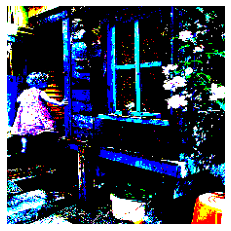

In [ ]:
import matplotlib.pyplot as plt
img = preprocess_img(IMAGE_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

Prepare image data according to the model

In [ ]:
# now get feature vector from images

def encode_image(img):
  img=preprocess_img(img)
  feature_vector=model_new.predict(img)
  #print(feature_vector.shape)
  feature_vector=feature_vector.reshape((-1,))
  return feature_vector

In [ ]:

(encode_image(IMAGE_PATH+"1000268201_693b08cb0e.jpg"))

array([0.04154292, 0.17076074, 0.2927856 , ..., 0.05089612, 0.31322378,
       0.8600749 ], dtype=float32)

In [ ]:
# now extract feature for all images in train data set
from time import time
start=time()
encoding_train={}

for ix,img_path in enumerate(train):
  
  path=IMAGE_PATH+img_path+'.jpg'
  encoding_train[img_path]=encode_image(path)
  if ix%100==0:
    print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
# now extract feature for all images in train data set
from time import time
start=time()


for ix,img_path in enumerate(dev):
  
  path=IMAGE_PATH+img_path+'.jpg'
  encoding_train[img_path]=encode_image(path)
  if ix%100==0:
    print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Total Time Taken : 832.9407918453217


In [ ]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMAGE_PATH+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 867.4859173297882


In [7]:
import pickle
PICKL_FILE=r'gdrive/My Drive/kaggle/flicker/flicker8k/PICKL_FILE/'

In [ ]:

with open(PICKL_FILE+"encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
with open(PICKL_FILE+"encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [8]:
# encoding_train = open(PICKL_FILE+"encoded_train_features.pkl", 'rb')      
# encoding_train = pickle.load(encoding_train)

with open(PICKL_FILE+"encoded_train_features.pkl", 'rb') as handle:
    encoding_train = pickle.load(handle)

In [ ]:
type(encoding_train)

dict

In [9]:
with open(PICKL_FILE+"encoded_test_features.pkl", 'rb') as handle:
    encoding_test = pickle.load(handle)

In [10]:
len(encoding_train)

7000

In [ ]:

(encode_image(IMAGE_PATH+"1000268201_693b08cb0e.jpg"))

array([0.04154292, 0.17076074, 0.2927856 , ..., 0.05089612, 0.31322378,
       0.8600749 ], dtype=float32)

In [ ]:
# Prepare caption data according to data

Data pre-processing for Captions

In [ ]:
# with open(DEFAULT_PATH+'unique_threshold_1.txt','w') as f:
#   for listitem in tot_words:
#     f.write('%s\n' % listitem)

tot_words = []

# open file and read the content in a list
with open(DEFAULT_PATH+'unique_threshold_1.txt', 'r') as f:
    for line in f:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        tot_words.append(currentPlace)

In [ ]:
len(tot_words)

1845

In [24]:
print(tot_words)

['in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', 'to', 'wearing', 'at', 'people', 'water', 'red', 'young', 'brown', 'an', 'his', 'blue', 'dogs', 'running', 'through', 'playing', 'while', 'shirt', 'down', 'standing', 'ball', 'little', 'grass', 'snow', 'child', 'person', 'jumping', 'over', 'three', 'front', 'sitting', 'holding', 'up', 'field', 'small', 'by', 'large', 'green', 'one', 'group', 'yellow', 'her', 'walking', 'children', 'men', 'into', 'air', 'beach', 'near', 'mouth', 'jumps', 'another', 'for', 'street', 'runs', 'its', 'from', 'riding', 'stands', 'as', 'bike', 'girls', 'outside', 'other', 'off', 'out', 'rock', 'next', 'play', 'orange', 'looking', 'pink', 'player', 'camera', 'their', 'pool', 'hat', 'jacket', 'boys', 'women', 'around', 'behind', 'some', 'background', 'dirt', 'toy', 'soccer', 'sits', 'dressed', 'has', 'wall', 'mountain', 'walks', 'crowd', 'along', 'plays', 'stand', 'looks', 'building', 'park', 'cl

In [25]:
len(tot_words)

1845

In [26]:
# now give each vocab a unique number like label encoder
# so we need to encode vocab->label
# and also need  another table   label->vocab

word_to_idx={}
idx_to_word={}

for idx,word in enumerate(tot_words):

  word_to_idx[word]=idx+1    # we are not using 0 indexiong to save it for padding the casptions
  idx_to_word[idx+1]=word

In [27]:
idx_to_word[word_to_idx['dog']]

'dog'

In [28]:
print(len(idx_to_word))

1845


In [29]:
# as we also have two special word startseq and endseq also ddd both word
word_to_idx['startseq']=1846
idx_to_word[1846]='starteq'

word_to_idx['endseq']=1847
idx_to_word[1847]='endseq'
vocab_size = len(word_to_idx) + 1   # as 0 is also included
print("Vocab Size",vocab_size)

Vocab Size 1848


In [30]:
with open(PICKL_FILE+"word_to_idx.pkl","wb") as f:
    pickle.dump(word_to_idx,f)

with open(PICKL_FILE+"idx_to_word.pkl","wb") as f:
    pickle.dump(idx_to_word,f)

In [22]:
with open(PICKL_FILE+"idx_to_word.pkl",'rb') as f:
    idx_to_word=pickle.load(f)

In [31]:
idx_to_word[1847]

'endseq'

In [34]:
vocab_size

1848

In [32]:
# as we will use rstm/rnn network to decide the unfold of network no of cells can be determined by=

# to keep thing simple we will use max of all captions as only the max length

import json
train_descriptions=None
with open(DEFAULT_PATH+'unique_threshold_start_end_seq.txt','r') as f:
  train_descriptions=f.read()
json_sting=train_descriptions.replace("'","\"")
train_descriptions=json.loads(json_sting)

max_=0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_=max(max_,len(cap.split(' ')))
print(max_)
max_len=max_

35


In [33]:
print("Vocab Size %d"%max_len)

Vocab Size 35


 We will predict the caption word by word. Thus, we need to encode each word into a fixed sized vector


In [39]:
# Data Loader (Generator)
import numpy as np

In [ ]:
encoding_train["1000268201_693b08cb0e"]

array([0.04154292, 0.17076074, 0.2927856 , ..., 0.05089612, 0.31322378,
       0.8600749 ], dtype=float32)

In [ ]:
# Word Embeddings

In [40]:
f=open('gdrive/My Drive/glove6b50dtxt/glove.6B.50d.txt',encoding='utf-8')
embedding_index={}
for line in f:
  value=line.split()

  word=value[0]
  values=np.array(value[1:],dtype='float32')
  embedding_index[word]=values

f.close()



In [41]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ], dtype=float32)

Now, for all unique words in our vocabulary, we create an embedding matrix which will be loaded into the model before training.

In [42]:
def get_embedding_matrix(vocab_size):
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [43]:
embedding_matrix = get_embedding_matrix(vocab_size)
embedding_matrix.shape

(1848, 50)

In [ ]:
embedding_matrix[5]

array([ 0.26818001,  0.14346001, -0.27877   ,  0.016257  ,  0.11384   ,
        0.69923002, -0.51332003, -0.47367999, -0.33074999, -0.13834   ,
        0.27020001,  0.30937999, -0.45012   , -0.4127    , -0.09932   ,
        0.038085  ,  0.029749  ,  0.10076   , -0.25058001, -0.51818001,
        0.34558001,  0.44922   ,  0.48791   , -0.080866  , -0.10121   ,
       -1.37769997, -0.10866   , -0.23201001,  0.012839  , -0.46507999,
        3.84629989,  0.31362   ,  0.13643   , -0.52244002,  0.33019999,
        0.33706999, -0.35600999,  0.32431   ,  0.12041   ,  0.35120001,
       -0.069043  ,  0.36884999,  0.25167999, -0.24517   ,  0.25380999,
        0.1367    , -0.31178001, -0.63209999, -0.25027999, -0.38097   ])

In [ ]:
# Model Architecture

Model Architecture

Since the input consists of two parts, an image vector and a partial caption, 
we cannot use the Sequential API provided by the Keras library. 

For this reason, we use the Functional API which allows us to create Merge Models.

In [44]:
# now making Keras API model of image
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [45]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [46]:
# merging both to one

decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [47]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [48]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

 since we are using a pre-trained embedding layer, we need to freeze it (trainable = False), before training the model, so that it does not get 

updated during the backpropagation.


Finally we compile the model using the adam optimizer

In [49]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [ ]:
# Training of model

# **Training of model**

In [19]:
epochs=10
batch_size=3
steps=len(train_descriptions)//batch_size




In [36]:
max_len,vocab_size

(35, 1848)

In [35]:

def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size,vocab_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            if key in encoding_train.keys():
              photo = encoding_train[key]
              for desc in desc_list:
                  
                  seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                  for i in range(1,len(seq)):
                      xi = seq[0:i]
                      yi = seq[i]
                      
                      #0 denote padding word
                      xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                      yi = to_categorical([yi],num_classes=vocab_size)[0]
                      
                      X1.append(photo)
                      X2.append(xi)
                      y.append(yi)
                      
                  if n==batch_size:
                      yield [[np.array(X1),np.array(X2)],np.array(y)]
                      X1,X2,y = [],[],[]
                      n = 0
              else:
                pass

In [1]:
MODEL_WEIGHT=r'gdrive/My Drive/ai bot/'

In [37]:
def train(epochs):
  for i in range(epochs):
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size,vocab_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    
    
    model.save(MODEL_WEIGHT+'model_'+str(i)+'.h5')

In [ ]:
train(epochs)

In [4]:
model = load_model(MODEL_WEIGHT+'model_9.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [ ]:
# Predictions

In [ ]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption
  

In [ ]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_ = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMAGE_PATH+img_name+".jpg")
    
    caption = predict_caption(photo_)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.